In [1]:
import torch
import torch.nn as nn
from torch.nn.functional import softmax
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.models import MobileNetV2
from mobilenetv3 import mobilenetv3
from albumentations import (Compose, HorizontalFlip, HueSaturationValue, Normalize, 
                            Resize, RandomCrop, RandomBrightnessContrast)
from albumentations.pytorch.transforms import ToTensor
import cv2
import os
import numpy as np
from PIL import Image
import torch.optim as optim
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
import time
import random

In [2]:
img_size = 224
img_transforms = Compose([
    HorizontalFlip(),
    HueSaturationValue(hue_shift_limit=10),
    RandomBrightnessContrast(),
    Normalize(mean=[0.485, 0.456, 0.406], 
             std=[0.229, 0.224, 0.225]),
    Resize(img_size, img_size),
    ToTensor()
])

In [3]:
def get_figure(image, label):
    min_v = torch.min(image)
    range_v = torch.max(image) - min_v
    if range_v > 0:
        normalised = (image - min_v) / range_v
    else:
        normalised = torch.zeros(image.size())
    img_np = normalised.permute(1, 2, 0).cpu().numpy()
    plt.figure()
    plt.imshow(img_np)
    plt.text(10, 50, label, fontsize=15, color='red')
    return plt.gcf()

In [4]:
def print_image(image, label, tag, writer, step=None):
    fig = get_figure(image, label)
    writer.add_figure(tag, fig, global_step=step)

In [5]:
def get_square_image(img):
    dim_diff = img.shape[0] - img.shape[1]
    if dim_diff > 0:
        img = img[:-dim_diff, :]
    if dim_diff < 0:
        img = img[:, -dim_diff // 2:dim_diff // 2]
    return img

In [6]:
class CelebaDataset(Dataset):
    def __init__(self, data_path, transform=None):
        with open(data_path) as f:
            file_content = f.read()
        lines = file_content.splitlines()[2:]
        self.images = []
        self.labels = []
        t1 = time.time()
        count_glasses = 0
        total = 0
        for i, line in enumerate(lines):
            self.images.append(line.split()[0])
            label = int(line.split()[1])
            count_glasses += label
            total += 1
            self.labels.append([1 - label, label])
        self.transform = transform
        print(count_glasses / total)
                
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        img_raw = Image.open(img_path).convert('RGB')
        img_raw.load()
        img = np.asarray(img_raw)
#         img = cv2.imread(img_path)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = get_square_image(img)
        data = {'image': img}
        if self.transform is not None:
            data = self.transform(**data)
        return data['image'], torch.tensor(label)

In [7]:
class ArtDataset(Dataset):
    def __init__(self, path_to_data, label, transform=None):
        self.images = []
        self.labels = []
        for f in os.listdir(path_to_data):
            self.images.append(os.path.join(path_to_data, f))
            self.labels.append(label)
        self.transform = transform
                
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        img_raw = Image.open(img_path).convert('RGB')
        img_raw.load()
        img = np.asarray(img_raw)
        img = get_square_image(img)
        data = {'image': img}
        if self.transform is not None:
            data = self.transform(**data)
        return data['image'], torch.tensor(label)

In [8]:
train_params = {'lr': 0.01, 'batch_size': 64}
batch_size = train_params['batch_size']

In [9]:
train_dataset = CelebaDataset('./train.txt', img_transforms)
test_dataset = CelebaDataset('./test.txt', img_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=20)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=20)

0.4130908807725255
0.39984520123839007


In [10]:
art_withglasses_dataset = ArtDataset('./example_data_glasses/with_glasses/', [0.0, 1.0], img_transforms)
art_withoutglasses_dataset = ArtDataset('./example_data_glasses/without_glasses/', [1.0, 0.0], img_transforms)
art_withglasses_dataloader = DataLoader(art_withglasses_dataset, batch_size=batch_size, shuffle=True, num_workers=20)
art_withoutglasses_dataloader = DataLoader(art_withoutglasses_dataset, batch_size=batch_size, shuffle=True, num_workers=20)

In [11]:
device = torch.device('cuda:0')
model = mobilenetv3(mode='small')
model.classifier._modules['1'] = nn.Linear(in_features=1280, out_features=2, bias=True)

In [12]:
state_dict = torch.load('./models/model_best')
keys = list(state_dict.keys())
for k in keys:
    new_k = k.replace('module.', '')
    state_dict[new_k] = state_dict.pop(k)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [13]:
for param in model.parameters():
    param.requires_grad = True

In [14]:
for param in model.classifier._modules['1'].parameters():
    param.requires_grad = True

In [15]:
#model = torch.hub.load('pytorch/vision:v0.4.2', 'mobilenet_v2', pretrained=True).to(device)
#model = MobileNetV2(num_classes=2, pretrained=True)
#model = torch.hub.load('pytorch/vision:v0.4.2', 'mobilenet_v2', pretrained=True)
#model.classifier._modules['1'] = nn.Linear(in_features=1280, out_features=2, bias=True) 
model = nn.DataParallel(model)
model = model.to(device)

In [16]:
#optimizer = optim.Adam(model.parameters(), lr=0.0001)
#optimizer = optim.RMSprop(model.parameters(), lr=train_params['lr'], weight_decay=0.9, momentum=0.9)
optimizer = optim.SGD(model.parameters(), lr=train_params['lr'], momentum=0.95, weight_decay=1e-6, nesterov=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.99)
criterion = nn.BCEWithLogitsLoss().to(device)

In [17]:
writer = SummaryWriter('runs4/run4_pretrained_balanced_unfreezed_bch={}_SGD_logits_lr={}_shed-98'
                       .format(train_params['batch_size'], train_params['lr']))

In [18]:
train_count = 0
test_count = 0

In [19]:
def test(model, test_dataloader, criterion, device=None, writer=None):
    global test_count
    if device is None:
        device = torch.device('cpu')

    test_loss = 0.0
    model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        for j, (images, labels) in enumerate(test_dataloader):
            images = images.to(device)
            labels = labels.float().to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(softmax(outputs).data, 1)
            _, labels_sng = torch.max(labels, 1)
            indicies = torch.range(0, len(outputs) - 1, dtype=torch.long)
            indicies = indicies[predicted != labels_sng]
            total += len(labels)
            correct += len(labels) - len(indicies)
            if j % 30 == 1:  
                if len(indicies) > 0 and writer is not None:
                    label = ("GT: ({}, {})\n" \
                             "Pred raw: ({:.2f}, {:.2f})\n" \
                             "Pred soft: ({:.2f}, {:.2f})\n" \
                             "Loss: ({:.2f})"
                            ).format(labels[indicies[0]][0].item(), labels[indicies[0]][1].item(), 
                                     outputs[indicies[0]][0].item(), outputs[indicies[0]][1].item(),
                                     softmax(outputs[indicies[0]])[0].item(), softmax(outputs[indicies[0]])[1].item(),
                                     criterion(outputs[indicies[0]], labels[indicies[0]]).item())
                    print_image(images[indicies[0]], label, "Test image wrong", writer, step=test_count)
        print("test_loss={:.2f}".format(test_loss / (j + 1)))
        print("test_accuracy={:.2f}".format(correct / total))
        if writer is not None:
            writer.add_scalar('test_loss', test_loss / (j + 1), test_count)
            writer.add_scalar('test_accuracy', correct / total, test_count)
            test_count += 1

In [20]:
def train(model, optimizer, scheduler, criterion, train_dataloader, epoch_num, device=None, test_dataloader=None, writer=None):
    global train_count
    if device is None:
        device = torch.device('cpu')
    model.train()
    for epoch in range(epoch_num):
        scheduler.step()
        running_loss = 0.0
        total = 0
        correct = 0
        for i, (images, labels) in enumerate(train_dataloader):
            images = images.to(device)
            labels = labels.float().to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(softmax(outputs).data, 1)
            _, labels_sng = torch.max(labels, 1)
            indicies = torch.range(0, len(outputs) - 1, dtype=torch.long)
            indicies = indicies[predicted != labels_sng]
            total += len(labels)
            correct += len(labels) - len(indicies)
            # print statistics
            running_loss += loss.item()
            if writer is not None:
                writer.add_scalar('train_loss', loss.item(), train_count)
                train_count += 1
            if i % 30 == 1: 
                if len(indicies) > 0 and writer is not None:
                    label = ("GT: ({}, {})\n" \
                             "Pred raw: ({:.2f}, {:.2f})\n" \
                             "Pred soft: ({:.2f}, {:.2f})\n" \
                             "Loss: ({:.2f})"
                            ).format(labels[indicies[0]][0].item(), labels[indicies[0]][1].item(), 
                                     outputs[indicies[0]][0].item(), outputs[indicies[0]][1].item(),
                                     softmax(outputs[indicies[0]])[0].item(), softmax(outputs[indicies[0]])[1].item(),
                                     criterion(outputs[indicies[0]], labels[indicies[0]]).item())
                    print_image(images[indicies[0]], label, "Train image wrong", writer, step=train_count)
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 30))
                running_loss = 0.0
        if writer is not None:
            writer.add_scalar('train_accuracy', correct / total, train_count)
        if test_dataloader is not None:
            test(model, test_dataloader, criterion, device=device, writer=writer)

In [78]:
train(model, optimizer, scheduler, criterion, train_dataloader, 500, device, test_dataloader, writer)

/home/main/anaconda3/envs/ternaus/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/home/main/anaconda3/envs/ternaus/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/main/anaconda3/envs/ternaus/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [s

[1,     2] loss: 0.003
[1,    32] loss: 0.058


KeyboardInterrupt: 

In [28]:
test(model, art_withoutglasses_dataloader, criterion, device=device)

test_loss=0.01
test_accuracy=1.00


/home/main/anaconda3/envs/ternaus/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/main/anaconda3/envs/ternaus/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].


In [21]:
def print_tensor(tensor):
    min_v = torch.min(tensor)
    range_v = torch.max(tensor) - min_v
    if range_v > 0:
        normalised = (tensor - min_v) / range_v
    else:
        normalised = torch.zeros(tensor.size())
    img_np = normalised.permute(1, 2, 0).cpu().numpy()
    plt.imshow(img_np)
    plt.show()

/home/main/anaconda3/envs/ternaus/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/main/anaconda3/envs/ternaus/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


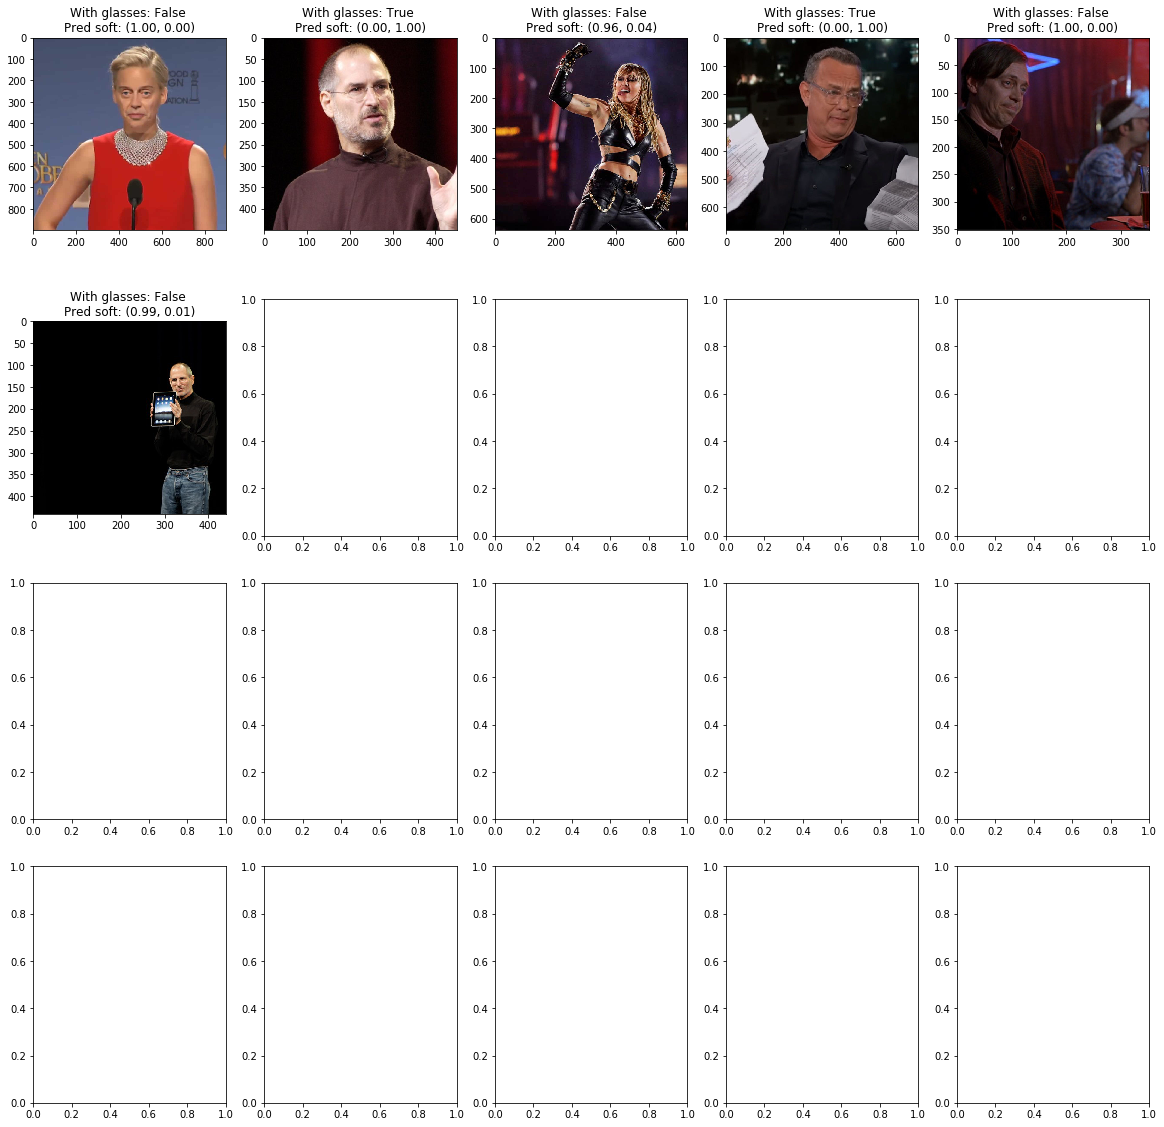

In [22]:
import itertools
left_r = list(range(4))
right_r = list(range(5))
indexes = itertools.product(left_r, right_r)
model.eval()
with torch.no_grad():
    total = 0
    correct = 0
    infer_time = 0
    dir_path = './dataset/test/'
    fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 20))
    for (i,j), f in zip(indexes, os.listdir(dir_path)):
        img_path = os.path.join(dir_path, f)
        img_raw = Image.open(img_path).convert('RGB')
        img_raw.load()
        img = np.asarray(img_raw)
        img = get_square_image(img)
        data = {'image': img}
        data = img_transforms(**data)
        
        img_tens = torch.unsqueeze(data['image'], 0)
        img_tens = img_tens.to(device)
        label = torch.tensor([[0.0, 1.0]]).to(device)
        
        t1 = time.time()
        output = model(img_tens)
        infer_time += time.time() - t1

        _, predicted = torch.max(softmax(output).data, 1)
        _, labels_sng = torch.max(label, 1)
        indicies = torch.tensor([0])
        missed = indicies[predicted != labels_sng]

        with_glasses = output[0][1] > output[0][0]
        tag = ("With glasses: {} \nPred soft: ({:.2f}, {:.2f})"
                ).format(with_glasses,
                         softmax(output[0])[0].item(), softmax(output[0])[1].item())
        axes[i, j].set_title(tag)
        axes[i, j].imshow(img)

In [297]:
torch.save(model.state_dict(), './models/model_best')